In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import arviz as az
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats
from scipy.stats import skewnorm
import scipy as sp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def dataimporter(filename,header=77,undregräns_b=2,övregränds_b=2.7):
    # Reading in the data file, removing header and converting it to a matrix
    data = pd.read_csv(filename, header=header)
    nummer = data.to_numpy()
    nummerdata = np.asarray(nummer[:-1,:], dtype="float")
    data = nummerdata
    
    #Fitting of the background and removal
    def bakgrund(x,c1,c2):
        return c1*x+c2
    bu = np.where(data[:,0]==find_nearest(data[:,0],undregräns_b))[0][0]
    bö = np.where(data[:,0]==find_nearest(data[:,0],övregränds_b))[0][0]
    xb = data[bu:bö,0]
    yb = data[bu:bö,1]
    poptb, popc = sp.optimize.curve_fit(bakgrund,xdata=xb,ydata=yb,p0=[0,0])
    data[:,1] = data[:,1]-bakgrund(data[:,0],*poptb)
    
    return nummerdata


def dataimporterclean(filename,header=70):
    # Reading in the data file, removing header and converting it to a matrix
    data = pd.read_csv(filename, header=header)
    nummer = data.to_numpy()
    nummerdata = np.asarray(nummer[:-1,:], dtype="float")
    return nummerdata

def bakgrund(x,c1,c2):
    return c1*x+c2

def plotter(ax,data,zo,colour,label,alpha = 1):
    # Function to plot spectrum
    ax.plot(data[:,0],data[:,1],zorder=zo, lw = 4, color = colour, label =label,alpha=alpha)
    ax.fill_between(data[:,0],data[:,1],zorder=zo, color = colour,alpha=alpha)
   
def find_nearest(array, value):
    # Function for finding closest value in array
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def data_integration(data,under=2,over=2.8,marginal=0.1):
    # Function to integrate the data between energies
    array = np.array([])
    for i in (data):
        intunder = np.where(i[:,0]==find_nearest(i[:,0],under))[0][0]
        intover = np.where(i[:,0]==find_nearest(i[:,0],over))[0][0]
        x=i[intunder:intover,0]
        y = i[intunder:intover,1]
        
        mitten = x[np.argmax(y)]

        u = np.where(x==find_nearest(x,mitten-marginal))[0][0]
        ö = np.where(x==find_nearest(x,mitten+marginal))[0][0]
        x=x[u:ö]
        y = y[u:ö]

        poptnorm,pcov = sp.optimize.curve_fit(norm,xdata=x,ydata=y,p0=[1,1,1])
        
        top1 =  np.sum(norm(x,*poptnorm))
        array = np.append(array,top1)
    return array


def data_integrationold(data,under=2.2,over=2.6,avgunder=2.65,avgover=2.8 ):
    # Function to integrate the data between energies
    array = np.array([])
    for i in (data):
        intunder = np.where(i[:,0]==find_nearest(i[:,0],under))
        intover = np.where(i[:,0]==find_nearest(i[:,0],over))
        placeunder = np.where(i[:,0]==find_nearest(i[:,0],avgunder))
        placeover = np.where(i[:,0]==find_nearest(i[:,0],avgover))
        
        intunder = np.reshape(intunder,-1)
        intover = np.reshape(intover,-1)
        placeunder = np.reshape(placeunder, -1)
        placeover = np.reshape(placeover, -1)

        # i[:,1] = i[:,1]-np.average(i[placeunder[0]:placeover[0],1])

        top1 = np.sum(i[intunder[0]:intover[0],1])
        array = np.append(array,top1)
    return array

def predict(signal,c):
    return c[0]*signal + c[1]

def readfile(arraynames):
    # Funstion to make it possible to import multiple files at the same time
    meaner = np.array([])
    for i in arraynames:
        temp = dataimporter(i)
        meaner = np.append(meaner,data_integration([temp]))
    return meaner

def skew_normal(x, a, loc, scale,amp):
    return amp*skewnorm.cdf(x, a, loc=loc, scale=scale)

def skew_normal_pdf(x, a, loc, scale,amp):
    return amp*skewnorm.pdf(x, a, loc=loc, scale=scale)
def norm(x,a,mean,sigma):
    return a*stats.norm.pdf(x,mean,sigma)

def invnorm(x,a,mean,sigma):
    return a*stats.invgauss.pdf(x,mean,sigma)

In [86]:

spectraldata10 = pd.DataFrame(columns=["tcps","tcpserror","prediction"])
c = [0.01099666 ,1.864586]

Prov1_Area1 = readfile(["Prov1_10K_area1_2.txt","Prov1_10K_area1_3.txt"])
spectraldata10.loc["Prov1_Area1"] = [np.mean(Prov1_Area1),(np.max(Prov1_Area1)-np.min(Prov1_Area1))/2,predict(np.mean(Prov1_Area1),c)]

Prov1_Area2 = readfile(["Prov1_10K_area2_2.txt","Prov1_10K_area2_1.txt","Prov1_10K_area2_3.txt"])
spectraldata10.loc["Prov1_Area2"] = [np.mean(Prov1_Area2),(np.max(Prov1_Area2)-np.min(Prov1_Area2))/2,predict(np.mean(Prov1_Area2),c)]

Prov1_Area3_1 = readfile(["Prov1_10K_area3_1.txt"])
spectraldata10.loc["Prov1_Area3_1"] = [np.mean(Prov1_Area3_1),(np.max(Prov1_Area3_1)-np.min(Prov1_Area3_1))/2,predict(np.mean(Prov1_Area3_1),c)]

Prov1_10K_area3_2 = readfile(["Prov1_10K_area3_2.txt"])
spectraldata10.loc["Prov1_10K_area3_2"] = [np.mean(Prov1_10K_area3_2),(np.max(Prov1_10K_area3_2)-np.min(Prov1_10K_area3_2))/2,predict(np.mean(Prov1_10K_area3_2),c)]
Prov1_10K_area3_3 = readfile(["Prov1_10K_area3_3.txt"])
spectraldata10.loc["Prov1_10K_area3_3"] = [np.mean(Prov1_10K_area3_3),(np.max(Prov1_10K_area3_3)-np.min(Prov1_10K_area3_3))/2,predict(np.mean(Prov1_10K_area3_3),c)]

Prov1_Area4_1 = readfile(["Prov1_10K_area4_1.txt"])
spectraldata10.loc["Prov1_Area4_1"] = [np.mean(Prov1_Area4_1),(np.max(Prov1_Area4_1)-np.min(Prov1_Area4_1))/2,predict(np.mean(Prov1_Area4_1),c)]

Prov2_10K_area1_1 = readfile(["Prov2_10K_area1_1.txt","Prov2_10K_area1_2.txt","Prov2_10K_area1_3.txt"])
spectraldata10.loc["Prov2_10K_area1_1"] = [np.mean(Prov2_10K_area1_1),(np.max(Prov2_10K_area1_1)-np.min(Prov2_10K_area1_1))/2,predict(np.mean(Prov2_10K_area1_1),c)]

print(spectraldata10)
sak = predict(np.array([326.812304-25,326.812304+25])/0.7,c)
print(sak[1]-sak[0])

                         tcps  tcpserror  prediction
Prov1_Area1        718.477310  75.053429    9.765437
Prov1_Area2        692.164525  25.758138    9.476084
Prov1_Area3_1      448.114851   0.000000    6.792353
Prov1_10K_area3_2  419.056571   0.000000    6.472809
Prov1_10K_area3_3  492.951114   0.000000    7.285402
Prov1_Area4_1      429.926990   0.000000    6.592347
Prov2_10K_area1_1  326.812304  51.871508    5.458430
0.7854757142857149


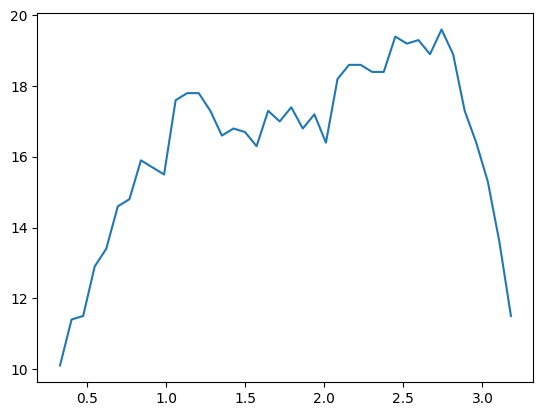

In [72]:
line1 = pd.read_csv("Line/Line Data 2.csv")
x = line1["Distance (µm)"].to_numpy()
y = line1["S Kα1 (counts)"].to_numpy() + line1["Mo Lα1 (counts)"].to_numpy()
x_med = np.array([])
y_med = np.array([])

med = 10
for i in range(len(x)-med):
    x_med = np.append(x_med, np.mean(x[i:i+med]))
    y_med = np.append(y_med, np.mean(y[i:i+med]))
    

plt.plot(x_med, y_med)
plt.show()

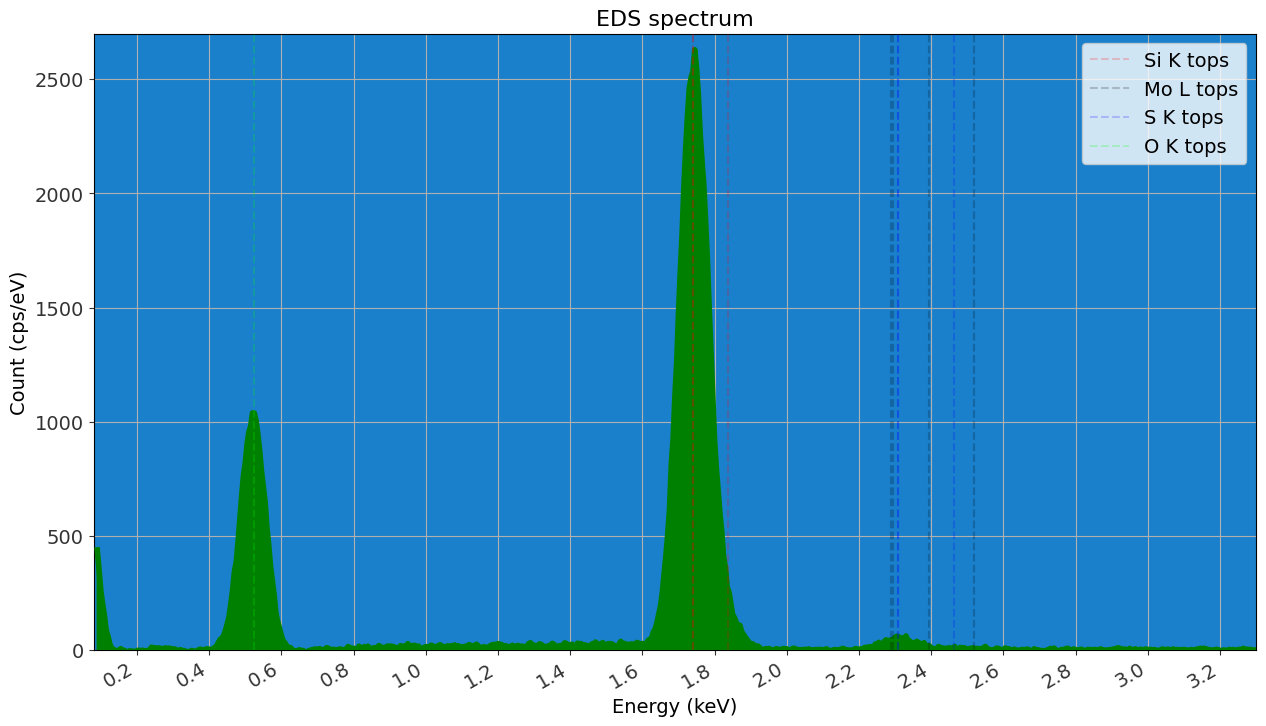

In [117]:
# Defining constants

Molines = [2.29316, 2.28985, 2.39481, 2.5183]
Silines = [1.73998,1.73938, 1.83594]
Slines = [2.30784,2.30664,2.46404]
Olines =[0.5249] 
Nticks = 20
xmax = 3.3
xmin = 0.08
ymax = 2700
marginal = 0.07

# Creating plot figure and tick formating function
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
fmt = lambda x, pos: '{}'.format(x).rstrip('0')

data = dataimporter("Prov1_10K_area1_2.txt")

#Fitting of the background
def bakgrund(x,c1,c2):
    return c1*x+c2
bu = np.where(data[:,0]==find_nearest(data[:,0],3))[0][0]
bö = np.where(data[:,0]==find_nearest(data[:,0],5))[0][0]

xb = data[bu:bö,0]
yb = data[bu:bö,1]

poptb, popc = sp.optimize.curve_fit(bakgrund,xdata=xb,ydata=yb,p0=[0,0])

data[:,1] = data[:,1]-bakgrund(data[:,0],*poptb)

#Fitting of gaussian on peak

intunder = np.where(data[:,0]==find_nearest(data[:,0],2))[0][0]
intover = np.where(data[:,0]==find_nearest(data[:,0],2.7))[0][0]

x=data[intunder:intover,0]
y = data[intunder:intover,1]

mitten = x[np.argmax(data[intunder:intover,1])]

u = np.where(x==find_nearest(x,mitten-marginal))[0][0]
ö = np.where(x==find_nearest(x,mitten+marginal))[0][0]
x=x[u:ö]
y = y[u:ö]

poptnorm,pcov = sp.optimize.curve_fit(norm,xdata=x,ydata=y,p0=[1,1,1])

# plotter(ax,dataimporter("Prov1_10K_area1_2.txt"),6,"darkgreen",None)
plotter(ax,data,6,"green",None)

# Setting parameters for plot
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right',fontsize=14)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.xaxis.set_major_locator(ticker.MaxNLocator(Nticks))
ax.grid(zorder = 1)
ax.set_xlim([xmin,xmax])
ax.set_ylim([0,ymax])
ax.set_facecolor((0.1, 0.5, 0.8))
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.xaxis.label.set_color('black')
ax.tick_params(colors=(0.2, 0.2, 0.2), which ='both')
ax.set_xlabel("Energy (keV)",fontsize=14)
ax.set_ylabel("Count (cps/eV)",fontsize=14)
ax.set_title("EDS spectrum",fontsize=16)

ax.vlines(Silines,-1000,ymax, colors="red",linestyles="dashed", alpha = 0.2, label="Si K tops",zorder = 10)#Silicon K tops
ax.vlines(Molines,-1000,ymax, colors="black",linestyles="dashed",alpha = 0.2,label= "Mo L tops",zorder = 10)#Mo L tops
ax.vlines(Slines,-1000,ymax, colors=(0,0,1),linestyles="dashed",alpha = 0.2,label= "S K tops",zorder = 10)#S K tops
ax.vlines(Olines,-1000,ymax, colors=(0,1,0),linestyles="dashed",alpha = 0.2,label= "O K tops",zorder = 10)#S K tops
ax.legend(fontsize=14)

# ax.hlines([12.5,16.5],-1000,ymax, colors="black",linestyles="dashed",alpha = 0.7,label= "Mo L tops",zorder = 10)
# ax.plot(data[intunder:intover,0],skew_normal_pdf(data[intunder:intover,0],*popt),zorder=10,color="w")
# ax.plot(x,norm(x,*poptnorm),zorder=10,color="b")
# ax.plot(data[:,0],bakgrund(data[:,0],*poptb),zorder=10,color="black",linestyle="-.")
plt.show()